In [1]:
MODEL_VERSION = "01"
NUM_TIMESTEPS = 28
RUN_ON_SAMPLE = False
SCALING = False

DROPOUT = 0.3
MIN_LR = 1e-4
MAX_LR = 1e-2
STEP_SIZE = 2
BATCH_SIZE = 10*1024
PREDICT_BATCH_SIZE = 20*1024
NUM_EPOCHS = [2, 8, 2]

In [2]:
import os, sys, datetime, pickle, gc
from time import time, ctime
from pprint import pprint

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from tensorflow.keras import Model, Input
from tensorflow.keras.layers import Conv1D, Conv2D, LSTM, Embedding, Dense, concatenate, TimeDistributed
from tensorflow.keras.layers import BatchNormalization, Dropout, Flatten, Reshape, Activation
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import RepeatVector, Lambda
from tensorflow.keras.backend import repeat_elements
from tensorflow.keras.callbacks import CSVLogger, ModelCheckpoint

import tensorflow_addons as tfa
from tensorflow_addons.optimizers import TriangularCyclicalLearningRate

In [3]:
physical_devices = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], enable=True)

In [4]:
seeded_value = 88888
pd.set_option('display.max_colwidth', 50)
np.random.seed(seeded_value)
tf.random.set_seed(seeded_value)

In [5]:
# suppress scientific notation
pd.options.display.precision = 2
np.set_printoptions(suppress=True)
pd.set_option('display.float_format', lambda x: '%.2f' % x)

In [6]:
print([
    tf.__version__
])

['2.2.0']


In [7]:
start_time = ctime(time())
print(start_time)

Thu Jun 25 08:57:13 2020


### Files
1. calendar.csv - Contains information about the dates on which the products are sold.
2. sales_train_validation.csv - Contains the historical daily unit sales data per product and store [d_1 - d_1913]
3. sample_submission.csv - The correct format for submissions. Reference the Evaluation tab for more info.
4. sell_prices.csv - Contains information about the price of the products sold per store and date.
5. sales_train_evaluation.csv - Includes sales [d_1 - d_1941] (labels used for the Public leaderboard)

In [8]:
DATA_DIR = "../data/"
RESULTS_DIR = "../results/"
PICKLE_DIR = "../data/preprocessed/"

Read about memory management in pandas [here](https://pythonspeed.com/articles/pandas-load-less-data/)

In [9]:
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

In [74]:
def read_data(infer_mode:bool=False):
    print('Reading files...')
    
    calendar = pd.read_csv('../data/calendar.csv').fillna("None")
    calendar = reduce_mem_usage(calendar)
    print('Calendar has {} rows and {} columns'.format(calendar.shape[0], calendar.shape[1]))
    
    sell_prices = pd.read_csv('../data/sell_prices.csv')
    sell_prices = reduce_mem_usage(sell_prices)
    print('Sell prices has {} rows and {} columns'.format(sell_prices.shape[0], sell_prices.shape[1]))
    
    if infer_mode:
        sales = pd.read_csv('../data/sales_train_evaluation.csv')
        print('Sales train validation has {} rows and {} columns'.format(sales.shape[0], sales.shape[1]))
    else:
        sales = pd.read_csv('../data/sales_train_validation.csv')
        print('Sales train validation has {} rows and {} columns'.format(sales.shape[0], sales.shape[1]))
    
    submission = pd.read_csv('../data/sample_submission.csv')
    
    pprint({
        "calendar.shape" : calendar.shape,
        "sell_prices.shape" : sell_prices.shape,
        "sales.shape" : sales.shape,
        "submission.shape" : submission.shape
    })
    
    return calendar, sell_prices, sales, submission

In [11]:
def add_dateparts(calendar, datecolname):
    calendar["Date"] = pd.to_datetime(calendar[datecolname], format = ("%Y-%m-%d"))
    calendar["Year"] = calendar["Date"].dt.year.astype('int16')
    calendar["Quarter"] = calendar["Date"].dt.quarter
    calendar["Month"] = calendar["Date"].dt.month
    calendar["Week"] = calendar["Date"].dt.week
    calendar["Day"] = calendar["Date"].dt.day
    calendar["DOW"] = calendar["Date"].dt.dayofweek
    calendar = reduce_mem_usage(calendar)
    return calendar

In [12]:
def melt_join_fill(sales, calendar, sell_prices):
    if RUN_ON_SAMPLE:
        sales = pd.melt(sales.sample(50),
                        id_vars=CARDINAL_VARS,
                        value_vars=Y_VARS,
                        var_name="day_id",
                        value_name='demand')
    else:
        sales = pd.melt(sales,
                        id_vars=CARDINAL_VARS,
                        value_vars=Y_VARS,
                        var_name="day_id",
                        value_name='demand')
    print("[INFO] ", "Melting  -- COMPLETE", ctime(time()))

    
    gc.collect()
    
    sales = pd.merge(sales, calendar, how="left", left_on="day_id", right_on="d")
    print("[INFO] ", "Merging1 -- COMPLETE", ctime(time()))
    
    gc.collect()
    
    sales = pd.merge(sales, sell_prices, how="left", on=["wm_yr_wk", "store_id", "item_id"])
    print("[INFO] ", "Merging2 -- COMPLETE", ctime(time()))
    
    gc.collect()
    
    # if sell_price is NA
    sales = sales.sort_values(by=CARDINAL_VARS+["date"])
    
    gc.collect()
    
    sales["sell_price_available"] = np.where(sales.sell_price.isna(), "N", "Y")
    sales[["sell_price"]] = sales.groupby(["item_id"])[["sell_price"]].ffill()
    sales[["sell_price"]] = sales.groupby(["item_id"])[["sell_price"]].bfill()
    sales = sales.drop(["d", "wday", 'date', 'wm_yr_wk', 'weekday', 'month', 'year'], axis=1)
    
    sales['day_id'] = sales['day_id'].astype(str).apply(lambda x: x[2:]).astype(np.int16)
    
    print("[INFO] ", "Imputing -- COMPLETE", ctime(time()))    
    
    gc.collect()
    
    sales['weights'] = sales["sell_price"] * sales["demand"]
    sales['rolling_weights'] = sales.groupby(CARDINAL_VARS)['weights'].rolling(window=NUM_TIMESTEPS, min_periods=1).sum().reset_index(drop=True)
    
    sales['weights'] = sales['weights'].apply(lambda x: np.max((1.0, x)))
    sales['rolling_weights'] = sales['rolling_weights'].apply(lambda x: np.max((1.0, x)))
    
    print("[INFO] ", "Weighting -- COMPLETE", ctime(time()))    
    
    gc.collect()
    
    print("[INFO] ", "Final dataset contains", sales.shape)
    
    return sales.reset_index(drop=True)

In [13]:
if not os.path.exists(PICKLE_DIR+"merged_df.pickle"):
    CARDINAL_VARS = ['state_id', 'store_id', 'cat_id', 'dept_id', 'item_id']
    
    calendar, sell_prices, sales, submission = read_data()
    
    calendar = add_dateparts(calendar, "date")
    
    Y_VARS = sales.columns[sales.columns.str.startswith("d_")]

    data = melt_join_fill(sales, calendar, sell_prices)
    
    del sales, calendar, sell_prices
    gc.collect()

    print("Saving all data to ---> ", PICKLE_DIR)
    with open(os.path.join(PICKLE_DIR, "merged_df.pickle"),"wb") as f:
        pickle.dump((data), f)
else:
    print("Pickle exists hence loading from pickle file ---> ", PICKLE_DIR)
    with open(os.path.join(PICKLE_DIR+"merged_df.pickle"), "rb") as f:
        data = pickle.load(f)

Pickle exists hence loading from pickle file --->  ../data/preprocessed/


In [14]:
1913-28, 1913, 1913 + 28, 1913 + 28 + 28

(1885, 1913, 1941, 1969)

In [15]:
data.Date.min(), data.Date.max()#, data.Date.max() + 28, data.Date.max() + 28 + 28

(Timestamp('2011-01-29 00:00:00'), Timestamp('2016-04-24 00:00:00'))

In [16]:
print(data.shape); data.head()

(58327370, 25)


,state_id,store_id,cat_id,dept_id,item_id,day_id,demand,event_name_1,event_type_1,event_name_2,...,Year,Quarter,Month,Week,Day,DOW,sell_price,sell_price_available,weights,rolling_weights
0,CA,CA_1,FOODS,FOODS_1,FOODS_1_001,1,3,None,None,None,...,2011,1,1,4,29,5,2.0,Y,6.0,33.60
1,CA,CA_1,FOODS,FOODS_1,FOODS_1_001,2,0,None,None,None,...,2011,1,1,4,30,6,2.0,Y,1.0,298.89
2,CA,CA_1,FOODS,FOODS_1,FOODS_1_001,3,0,None,None,None,...,2011,1,1,5,31,0,2.0,Y,1.0,21.88
3,CA,CA_1,FOODS,FOODS_1,FOODS_1_001,4,1,None,None,None,...,2011,1,2,5,1,1,2.0,Y,2.0,167.45
4,CA,CA_1,FOODS,FOODS_1,FOODS_1_001,5,4,None,None,None,...,2011,1,2,5,2,2,2.0,Y,8.0,38.09


# Preprocessing

In [17]:
CONT_VARS = ['snap_CA', 'snap_TX', 'snap_WI', 'sell_price']
CAT_VARS = ['state_id', 'store_id', 'cat_id', 'dept_id', 'item_id', 'event_name_1',
            'event_type_1', 'event_name_2', 'event_type_2', 'Year', 'Quarter',
            'Month', 'Week', 'Day', 'DOW', 'sell_price_available']
DEP_VAR = ['demand']
WEIGHT_VAR = ['weights', 'rolling_weights']

### Categorical Data

In [18]:
Category_Mapping = {}
for c in CAT_VARS:
    # convert columns to categories
    data[c+"_cat"] = data[c].astype("category")
    
    # save the mapping for later use
    Category_Mapping.update({c+"_cat" : dict(enumerate(data[c+"_cat"].cat.categories))})
    
    # Copy categories as integer codes
    data[c+"_cat"] = data[c+"_cat"].cat.codes

In [19]:
Unique_Dict ={}
for c in CAT_VARS:
    col = c+"_cat"
    Unique_Dict.update({col:{'min':data[col].min(), 
                             'max':data[col].max(), 
                             'nuniq':data[col].nunique(), 
                             'emb_sz':max(min(int(data[col].nunique() / 2), 10), 2)}})
pprint(Unique_Dict)

{'DOW_cat': {'emb_sz': 3, 'max': 6, 'min': 0, 'nuniq': 7},
 'Day_cat': {'emb_sz': 10, 'max': 30, 'min': 0, 'nuniq': 31},
 'Month_cat': {'emb_sz': 6, 'max': 11, 'min': 0, 'nuniq': 12},
 'Quarter_cat': {'emb_sz': 2, 'max': 3, 'min': 0, 'nuniq': 4},
 'Week_cat': {'emb_sz': 10, 'max': 52, 'min': 0, 'nuniq': 53},
 'Year_cat': {'emb_sz': 3, 'max': 5, 'min': 0, 'nuniq': 6},
 'cat_id_cat': {'emb_sz': 2, 'max': 2, 'min': 0, 'nuniq': 3},
 'dept_id_cat': {'emb_sz': 3, 'max': 6, 'min': 0, 'nuniq': 7},
 'event_name_1_cat': {'emb_sz': 10, 'max': 30, 'min': 0, 'nuniq': 31},
 'event_name_2_cat': {'emb_sz': 2, 'max': 4, 'min': 0, 'nuniq': 5},
 'event_type_1_cat': {'emb_sz': 2, 'max': 4, 'min': 0, 'nuniq': 5},
 'event_type_2_cat': {'emb_sz': 2, 'max': 2, 'min': 0, 'nuniq': 3},
 'item_id_cat': {'emb_sz': 10, 'max': 3048, 'min': 0, 'nuniq': 3049},
 'sell_price_available_cat': {'emb_sz': 2, 'max': 1, 'min': 0, 'nuniq': 2},
 'state_id_cat': {'emb_sz': 2, 'max': 2, 'min': 0, 'nuniq': 3},
 'store_id_cat': {'e

In [20]:
NEW_CAT_VARS = [col+"_cat" for col in CAT_VARS]

### Numerical Data

In [21]:
if SCALING:
    MMS = MinMaxScaler()
    data[CONT_VARS] = MMS.fit_transform(data[CONT_VARS])

    MMS_Y = MinMaxScaler(feature_range=(0, 0.8))
    data[DEP_VAR] = MMS_Y.fit_transform(data[DEP_VAR])

# Cross Validation

In [22]:
TRAIN_INDICES = np.arange(1, 1885 + 1) # Could use 1156
VALID_INDICES = np.arange(1886, 1913 + 1)
PUBLIC_INDICES = np.arange(1914, 1941 + 1)
PRIVATE_INDICES = np.arange(1942, 1969 + 1)

In [23]:
print(min(TRAIN_INDICES), max(TRAIN_INDICES), len(TRAIN_INDICES))
print(min(VALID_INDICES), max(VALID_INDICES), len(VALID_INDICES))
print(min(PUBLIC_INDICES), max(PUBLIC_INDICES), len(PUBLIC_INDICES))
print(min(PRIVATE_INDICES), max(PRIVATE_INDICES), len(PRIVATE_INDICES))

1 1885 1885
1886 1913 28
1914 1941 28
1942 1969 28


In [24]:
train_data = data.loc[data.day_id.isin(TRAIN_INDICES)]
valid_data = data.loc[data.day_id.isin(VALID_INDICES)]
train_data.shape, valid_data.shape

((57473650, 41), (853720, 41))

In [25]:
data.shape[0] == train_data.shape[0] + valid_data.shape[0]

True

# Model Specification

In [26]:
def build_model():
    layers = []
    inputs = []
    for i,col in enumerate(CAT_VARS):
        input_ = Input(shape=1, name=col+"_cat")
        embedding =  Embedding(Unique_Dict[col+"_cat"]['nuniq'],
                               Unique_Dict[col+"_cat"]['emb_sz'],
                               name='emb_'+col)(input_)
        vec = Flatten()(embedding)
        layers.append(vec)
        inputs.append(input_)
    
    for i, col in enumerate(CONT_VARS):
        input_ = Input(shape=1, name=col)
        layers.append(input_)
        inputs.append(input_)
    
    concat_layer = concatenate(layers)
    x = Dense(2048)(concat_layer)
    x = BatchNormalization()(x)
    x = Dropout(DROPOUT)(x)
    x = Activation('relu')(x)

    x = Dense(1024)(x)
    x = BatchNormalization()(x)
    x = Dropout(DROPOUT)(x)
    x = Activation('relu')(x)

    x = Dense(512)(x)
    x = BatchNormalization()(x)
    x = Dropout(DROPOUT)(x)
    x = Activation('relu')(x)
    
    x = Dense(256)(x)
    x = BatchNormalization()(x)
    x = Dropout(DROPOUT)(x)
    x = Activation('relu')(x)
    
    x = Dense(128)(x)
    x = BatchNormalization()(x)
    x = Dropout(DROPOUT)(x)
    x = Activation('relu')(x)
    
    x = Dense(64)(x)
    x = BatchNormalization()(x)
    x = Dropout(DROPOUT)(x)
    x = Activation('relu')(x)
    
    x = Dense(32)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    if SCALING:
        demand = Dense(1, activation='sigmoid', name='demand')(x)
    else:
        demand = Dense(1, activation='relu', name='demand')(x)
    
    model = Model(inputs, demand)
    
    return model

In [27]:
model = build_model()

In [28]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
state_id_cat (InputLayer)       [(None, 1)]          0                                            
__________________________________________________________________________________________________
store_id_cat (InputLayer)       [(None, 1)]          0                                            
__________________________________________________________________________________________________
cat_id_cat (InputLayer)         [(None, 1)]          0                                            
__________________________________________________________________________________________________
dept_id_cat (InputLayer)        [(None, 1)]          0                                            
______________________________________________________________________________________________

In [29]:
if os.path.exists(RESULTS_DIR+"BestCheckpoint_"+MODEL_VERSION+".h5"):
    model.load_weights(RESULTS_DIR+"BestCheckpoint_"+MODEL_VERSION+".h5")

In [30]:
tclr = TriangularCyclicalLearningRate(
    initial_learning_rate=MIN_LR,
    maximal_learning_rate=MAX_LR,
    step_size=STEP_SIZE*len(train_data)
)

In [31]:
mcp = ModelCheckpoint(filepath=RESULTS_DIR+"BestCheckpoint_"+MODEL_VERSION+".h5", monitor='val_loss',
                      verbose=0, save_best_only=True, save_weights_only=False, mode='min', save_freq='epoch')
csvl = CSVLogger(filename=RESULTS_DIR+"LossLogs_"+MODEL_VERSION+".csv",
                 separator=",", append=True)

In [32]:
adam = Adam(learning_rate=MAX_LR)
model.compile(loss='mse', optimizer=adam)

In [33]:
history = model.fit(x=train_data[NEW_CAT_VARS + CONT_VARS].to_dict(orient='series'),
                    y=train_data[DEP_VAR].to_dict(orient='series'),
                    validation_data=(valid_data[NEW_CAT_VARS + CONT_VARS].to_dict(orient='series'),
                                     valid_data[DEP_VAR].to_dict(orient='series'),
#                                      valid_data[WEIGHT_VAR].to_dict(orient='series')['rolling_weights']
                                    ),
                    batch_size=BATCH_SIZE,
                    epochs=NUM_EPOCHS[0],
                    shuffle=True,
                    verbose=1,
#                     sample_weight=train_data[WEIGHT_VAR].to_dict(orient='series')['rolling_weights'],
                    callbacks=[mcp, csvl])

Epoch 1/2
5613/5613 [==============================] - 912s 162ms/step - loss: 6.8942 - val_loss: 5.4529
Epoch 2/2
5613/5613 [==============================] - 910s 162ms/step - loss: 5.9111 - val_loss: 5.2774


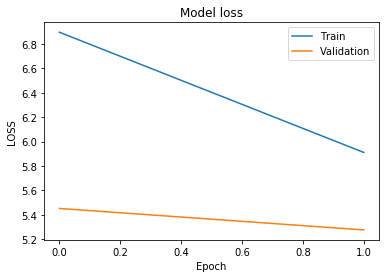

In [34]:
metric_names = ['loss']

for i, j in zip(metric_names, ['val_'+i for i in metric_names]):
    plt.plot(history.history[i])
    plt.plot(history.history[j])
    plt.title('Model '+i)
    plt.ylabel(i.upper())
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'])
    plt.show()

In [35]:
adam = Adam(learning_rate=tclr)
model.compile(loss='mse', optimizer=adam)

In [36]:
history = model.fit(x=train_data[NEW_CAT_VARS + CONT_VARS].to_dict(orient='series'),
                    y=train_data[DEP_VAR].to_dict(orient='series'),
                    validation_data=(valid_data[NEW_CAT_VARS + CONT_VARS].to_dict(orient='series'),
                                     valid_data[DEP_VAR].to_dict(orient='series'),
#                                      valid_data[WEIGHT_VAR].to_dict(orient='series')['rolling_weights']
                                    ),
                    batch_size=BATCH_SIZE,
                    epochs=NUM_EPOCHS[1],
                    shuffle=True,
                    verbose=1, 
#                     sample_weight=train_data[WEIGHT_VAR].to_dict(orient='series')['rolling_weights'],
                    callbacks=[mcp, csvl])

Epoch 1/8
5613/5613 [==============================] - 909s 162ms/step - loss: 5.4266 - val_loss: 5.1465
Epoch 2/8
5613/5613 [==============================] - 909s 162ms/step - loss: 5.2010 - val_loss: 5.1115
Epoch 3/8
5613/5613 [==============================] - 909s 162ms/step - loss: 5.3333 - val_loss: 5.1098
Epoch 4/8
5613/5613 [==============================] - 909s 162ms/step - loss: 5.2933 - val_loss: 5.0938
Epoch 5/8
5613/5613 [==============================] - 909s 162ms/step - loss: 5.2690 - val_loss: 5.0892
Epoch 6/8
5613/5613 [==============================] - 909s 162ms/step - loss: 5.2425 - val_loss: 5.0821
Epoch 7/8
5613/5613 [==============================] - 909s 162ms/step - loss: 5.2241 - val_loss: 5.0677
Epoch 8/8
5613/5613 [==============================] - 908s 162ms/step - loss: 5.1998 - val_loss: 5.0681


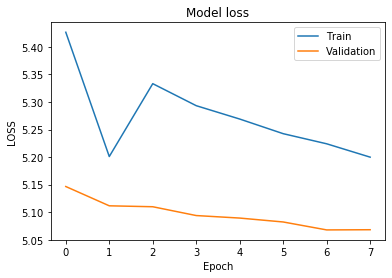

In [37]:
metric_names = ['loss']

for i, j in zip(metric_names, ['val_'+i for i in metric_names]):
    plt.plot(history.history[i])
    plt.plot(history.history[j])
    plt.title('Model '+i)
    plt.ylabel(i.upper())
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'])
    plt.show()

In [38]:
adam = Adam(learning_rate=MIN_LR*0.1)
model.compile(loss='mse', optimizer=adam)

In [39]:
history = model.fit(x=train_data[NEW_CAT_VARS + CONT_VARS].to_dict(orient='series'),
                    y=train_data[DEP_VAR].to_dict(orient='series'),
                    validation_data=(valid_data[NEW_CAT_VARS + CONT_VARS].to_dict(orient='series'),
                                     valid_data[DEP_VAR].to_dict(orient='series'),
#                                      valid_data[WEIGHT_VAR].to_dict(orient='series')['rolling_weights']
                                    ),
                    batch_size=BATCH_SIZE,
                    epochs=NUM_EPOCHS[2],
                    shuffle=True,
                    verbose=1, 
#                     sample_weight=train_data[WEIGHT_VAR].to_dict(orient='series')['rolling_weights'],
                    callbacks=[mcp, csvl])

Epoch 1/2
5613/5613 [==============================] - 908s 162ms/step - loss: 5.1241 - val_loss: 5.0647
Epoch 2/2
5613/5613 [==============================] - 908s 162ms/step - loss: 5.0037 - val_loss: 5.0620


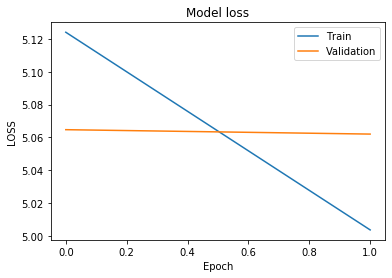

In [40]:
metric_names = ['loss']

for i, j in zip(metric_names, ['val_'+i for i in metric_names]):
    plt.plot(history.history[i])
    plt.plot(history.history[j])
    plt.title('Model '+i)
    plt.ylabel(i.upper())
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'])
    plt.show()

In [79]:
model.save(filepath=RESULTS_DIR+"FinalCheckpoint_"+MODEL_VERSION+".h5", overwrite=True)

# Validation

In [83]:
model = tf.keras.models.load_model(filepath=RESULTS_DIR+"FinalCheckpoint_"+MODEL_VERSION+".h5")

In [84]:
if os.path.exists(RESULTS_DIR+"BestCheckpoint_"+MODEL_VERSION+".h5"):
    model.load_weights(RESULTS_DIR+"BestCheckpoint_"+MODEL_VERSION+".h5")

In [41]:
train_preds = model.predict(train_data[NEW_CAT_VARS + CONT_VARS].to_dict(orient='series'),
                            batch_size=PREDICT_BATCH_SIZE, verbose=1)
valid_preds = model.predict(valid_data[NEW_CAT_VARS + CONT_VARS].to_dict(orient='series'),
                            batch_size=PREDICT_BATCH_SIZE, verbose=1)
print(train_preds.shape, valid_preds.shape)

42/42 [==============================] - 3s 73ms/step
(57473650, 1) (853720, 1)


In [42]:
if SCALING:
    train_demand = MMS_Y.inverse_transform(train_preds)
    valid_demand = MMS_Y.inverse_transform(valid_preds)

    data['prediction'] = 0
    data[['prediction']].loc[data.day_id.isin(TRAIN_INDICES)] = train_preds
    data[['prediction']].loc[data.day_id.isin(VALID_INDICES)] = valid_preds

    data['demand_Unscaled'] = MMS_Y.inverse_transform(data[['demand']])
    data[[col+'_Unscaled' for col in CONT_VARS]] = pd.DataFrame(MMS.inverse_transform(data[CONT_VARS]))

In [52]:
train_preds.sum(), valid_preds.sum(), train_preds.sum() + valid_preds.sum(), data['demand'].sum()

(66964796.0, 1205207.4, 68170000.0, 65695409)

In [67]:
data['pred_demand'] = 0

if SCALING:
    data['pred_demand'].loc[data.day_id.isin(TRAIN_INDICES)] = train_demand.flatten()
    data['pred_demand'].loc[data.day_id.isin(VALID_INDICES)] = valid_demand.flatten()
else:
    data['pred_demand'].loc[data.day_id.isin(TRAIN_INDICES)] = train_preds.flatten()
    data['pred_demand'].loc[data.day_id.isin(VALID_INDICES)] = valid_preds.flatten()

/anaconda/envs/py37_tensorflow/lib/python3.7/site-packages/pandas/core/indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


In [70]:
# Is the distribution same?
data[['demand','pred_demand']].describe()

,demand,pred_demand
count,58327370.00,58327370.00
mean,1.13,1.17
std,3.87,3.10
min,0.00,-0.44
25%,0.00,0.26
50%,0.00,0.44
75%,1.00,1.08
max,763.00,560.96


In [71]:
# Is the distribution same?
data[['demand','pred_demand']].groupby(np.where(data.day_id.isin(TRAIN_INDICES),"Train","Valid")).describe()

demand                                      pred_demand            \
            count mean  std  min  25%  50%  75%    max       count mean  std   
Train 57473650.00 1.12 3.88 0.00 0.00 0.00 1.00 763.00 57473650.00 1.17 3.10   
Valid   853720.00 1.39 3.59 0.00 0.00 0.00 1.00 204.00   853720.00 1.41 2.81   

                                   
        min  25%  50%  75%    max  
Train -0.44 0.26 0.44 1.08 560.96  
Valid  0.14 0.38 0.69 1.40 157.71

# Inference

In [73]:
print("Variables needed for Inference:")
NEW_CAT_VARS + CONT_VARS

Variables needed for Inference:


['state_id_cat',
 'store_id_cat',
 'cat_id_cat',
 'dept_id_cat',
 'item_id_cat',
 'event_name_1_cat',
 'event_type_1_cat',
 'event_name_2_cat',
 'event_type_2_cat',
 'Year_cat',
 'Quarter_cat',
 'Month_cat',
 'Week_cat',
 'Day_cat',
 'DOW_cat',
 'sell_price_available_cat',
 'snap_CA',
 'snap_TX',
 'snap_WI',
 'sell_price']

In [ ]:
if not os.path.exists(PICKLE_DIR+"merged_df_test.pickle"):
    CARDINAL_VARS = ['state_id', 'store_id', 'cat_id', 'dept_id', 'item_id']
    
    calendar, sell_prices, test_sales, submission = read_data(infer_mode=True)
    
    calendar = add_dateparts(calendar, "date")
    
    Y_VARS = test_sales.columns[test_sales.columns.str.startswith("d_")]

    test_data = melt_join_fill(test_sales, calendar, sell_prices)
    
    del test_sales, calendar, sell_prices
    gc.collect()

    print("Saving all data to ---> ", PICKLE_DIR)
    with open(os.path.join(PICKLE_DIR, "merged_df_test.pickle"),"wb") as f:
        pickle.dump((test_data), f)
else:
    print("Pickle exists hence loading from pickle file ---> ", PICKLE_DIR)
    with open(os.path.join(PICKLE_DIR+"merged_df_test.pickle"), "rb") as f:
        data = pickle.load(f)

In [75]:
discard = pd.read_csv('../data/sales_train_evaluation.csv', nrows=100)

In [76]:
discard.head()

,id,item_id,dept_id,cat_id,store_id,state_id,d_1,d_2,d_3,d_4,...,d_1932,d_1933,d_1934,d_1935,d_1936,d_1937,d_1938,d_1939,d_1940,d_1941
0,HOBBIES_1_001_CA_1_evaluation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,2,4,0,0,0,0,3,3,0,1
1,HOBBIES_1_002_CA_1_evaluation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,0,1,2,1,1,0,0,0,0,0
2,HOBBIES_1_003_CA_1_evaluation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,1,0,2,0,0,0,2,3,0,1
3,HOBBIES_1_004_CA_1_evaluation,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,1,1,0,4,0,1,3,0,2,6
4,HOBBIES_1_005_CA_1_evaluation,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,0,0,0,2,1,0,0,2,1,0


In [77]:
discard.columns

Index(['id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id', 'd_1',
       'd_2', 'd_3', 'd_4',
       ...
       'd_1932', 'd_1933', 'd_1934', 'd_1935', 'd_1936', 'd_1937', 'd_1938',
       'd_1939', 'd_1940', 'd_1941'],
      dtype='object', length=1947)

In [78]:
discard.shape

(100, 1947)

1 1885 1885
1886 1913 28
1914 1941 28
1942 1969 28

#### Scaling is shit... Do it for the whole 2D array instead -- Now it is MinMax 0.1-0.9 Scaling -- No Scaling is Better it seems
#### Add weights during training... inside the fit call you need dynamic weighting -- Now both Train and Valid samples are weighted
#### Add More Features  -- More features have been added

## Add Conv1D -- Not done yet

## Make use of Dask instead of pandas